In [76]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
import os
import seaborn as sns

In [77]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [78]:
fileName = 'C:/Users/mcarp/Downloads/usa_00007.csv/usa_00007.csv'
file = pd.read_csv(fileName)
dfCDI = pd.DataFrame(file)

In [79]:
fileName2 = 'C:/Users/mcarp/Downloads/county_merged_vals - Sheet1.csv'
file2 = pd.read_csv(fileName2)
dfCty = pd.DataFrame(file2)

In [80]:
dfCDI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1887461 entries, 0 to 1887460
Data columns (total 40 columns):
 #   Column      Dtype  
---  ------      -----  
 0   YEAR        int64  
 1   MULTYEAR    int64  
 2   SAMPLE      int64  
 3   SERIAL      int64  
 4   CBSERIAL    int64  
 5   HHWT        float64
 6   CLUSTER     int64  
 7   CPI99       float64
 8   STATEFIP    int64  
 9   COUNTYFIP   int64  
 10  DENSITY     float64
 11  CITY        int64  
 12  PUMA        int64  
 13  STRATA      int64  
 14  GQ          int64  
 15  OWNERSHP    int64  
 16  OWNERSHPD   int64  
 17  OWNCOST     int64  
 18  RENTGRS     int64  
 19  HHINCOME    int64  
 20  CILAPTOP    int64  
 21  CIHISPEED   int64  
 22  PERNUM      int64  
 23  PERWT       float64
 24  FAMSIZE     int64  
 25  AGE         int64  
 26  RACE        int64  
 27  RACED       int64  
 28  HISPAN      int64  
 29  HISPAND     int64  
 30  EDUC        int64  
 31  EDUCD       int64  
 32  OCCSOC      object 
 33  INDNAIC

In [81]:
dfCDI.shape

(1887461, 40)

In [82]:
dfCDI = dfCDI[dfCDI['AGE']>=21]
dfCDI.shape

(1417874, 40)

In [83]:
dfCDI.RENTGRS.value_counts()

0       941339
1252      1640
1460      1534
1619      1222
1079      1172
         ...  
4263         1
332          1
3996         1
57           1
197          1
Name: RENTGRS, Length: 4547, dtype: int64

In [84]:
dfHomeOwn=dfCDI[dfCDI['OWNERSHP']==1]
dfHomeOwn.RENTGRS.describe()

count    863826.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: RENTGRS, dtype: float64

This reveals that home owning rows all have 0 values for cost of rent.

In [85]:
dfCDI['OWNERSHP'].value_counts()

1    863826
2    494178
0     59870
Name: OWNERSHP, dtype: int64

In [86]:
dfCDI = dfCDI[dfCDI['OWNERSHP']!=0]
dfCDI.shape

(1358004, 40)

Removes N/As (~50k rows)

In [87]:
dfCDI['RENTGRS'].value_counts()

0       881469
1252      1640
1460      1534
1619      1222
1079      1172
         ...  
4263         1
332          1
3996         1
57           1
197          1
Name: RENTGRS, Length: 4547, dtype: int64

In [88]:
dfCDI['affrentdec'] = dfCDI['RENTGRS']*12/dfCDI['HHINCOME']

In [89]:
def housingFunc(own, affrentdec):
    if own==1:
        housingCat=2
    elif own==2 and affrentdec<.3:
        housingCat=1
    else:
        housingCat=0
    return housingCat

In [90]:
dfCDI['HousingCat'] = dfCDI.apply(lambda x: housingFunc(x['OWNERSHP'], x['affrentdec']), axis=1)
dfCDI['HousingCat'].value_counts()

2    863826
1    261051
0    233127
Name: HousingCat, dtype: int64

COMBINING aff. rent and home ownership into 1 indicator: 0, 1, 2 scores (0: rent>=30% income, 1: rent<30% income, 2: owner)

In [91]:
dfCDI['EDUCbin'] = [1 if x >=8 else 0 for x in dfCDI['EDUC']]
dfCDI['EDUCbin'].value_counts()

0    761987
1    596017
Name: EDUCbin, dtype: int64

In [92]:
dfCDI['CIHISPEED'].value_counts()

10    1047257
20     176856
0      133891
Name: CIHISPEED, dtype: int64

In [93]:
dfCDI = dfCDI[dfCDI['CIHISPEED']!=0]

In [94]:
dfCDI['TRANTIME'].value_counts()

0      510201
30     105754
15      96661
20      96467
10      73306
        ...  
104         1
117         1
116         1
103         1
113         1
Name: TRANTIME, Length: 120, dtype: int64

In [95]:
dfCDI.shape

(1224113, 43)

## County-level merge

In [96]:
joined2019_2 = dfCDI.merge(dfCty, on='COUNTYFIP')
joined2019_2.shape

(1180785, 60)

In [97]:
print(joined2019_2.columns.get_loc("HousingCat"))
print(joined2019_2.columns.get_loc("EDUCbin"))
print(joined2019_2.columns.get_loc("CIHISPEED"))
print(joined2019_2.columns.get_loc("TRANTIME"))
print(joined2019_2.columns.get_loc("DrinkingWater"))
print(joined2019_2.columns.get_loc("AirQuality"))
print(joined2019_2.columns.get_loc("EarlyEd"))
print(joined2019_2.columns.get_loc("ProspNeigh"))

41
42
21
39
56
58
57
59


In [98]:
X = joined2019_2.iloc[:, [41,42,21,39,56,58,57,59]]

In [99]:
X.describe()

,HousingCat,EDUCbin,CIHISPEED,TRANTIME,DrinkingWater,AirQuality,EarlyEd,ProspNeigh
count,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06
mean,1.495227e+00,4.688491e-01,1.139179e+01,1.802718e+01,9.943121e-01,3.523099e+01,5.149841e-01,8.171870e-01
std,7.505296e-01,4.990289e-01,3.461329e+00,2.410094e+01,1.992936e-02,6.126561e+00,8.383225e-02,1.154902e-01
min,0.000000e+00,0.000000e+00,1.000000e+01,0.000000e+00,8.888183e-01,1.700000e+01,3.260000e-01,3.646189e-01
25%,1.000000e+00,0.000000e+00,1.000000e+01,0.000000e+00,9.996217e-01,3.000000e+01,4.570000e-01,7.592451e-01
50%,2.000000e+00,0.000000e+00,1.000000e+01,1.000000e+01,9.999295e-01,3.700000e+01,5.450000e-01,8.183911e-01
75%,2.000000e+00,1.000000e+00,1.000000e+01,3.000000e+01,1.000000e+00,4.000000e+01,5.540000e-01,8.968348e-01
max,2.000000e+00,1.000000e+00,2.000000e+01,1.420000e+02,1.000000e+00,4.300000e+01,7.440000e-01,9.960382e-01


## Standardization:

In [100]:
scaler=StandardScaler()
scalerNum = scaler.fit(X)
Xstd = scalerNum.transform(X)

In [101]:
dfX = pd.DataFrame(Xstd, columns=['HousingCat','EDUCbin','CIHISPEED','TRANTIME','DrinkingWater','AirQuality','EarlyEd','ProspNeigh'])
dfX.describe()

,HousingCat,EDUCbin,CIHISPEED,TRANTIME,DrinkingWater,AirQuality,EarlyEd,ProspNeigh
count,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06
mean,7.065428e-13,-4.973875e-14,8.830854e-14,-4.389707e-13,-2.740658e-13,1.435436e-12,-3.516910e-12,5.989656e-13
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.992230e+00,-9.395234e-01,-4.020960e-01,-7.479869e-01,-5.293388e+00,-2.975731e+00,-2.254314e+00,-3.918673e+00
25%,-6.598374e-01,-9.395234e-01,-4.020960e-01,-7.479869e-01,2.664198e-01,-8.538214e-01,-6.916685e-01,-5.017038e-01
50%,6.725556e-01,-9.395234e-01,-4.020960e-01,-3.330653e-01,2.818670e-01,2.887450e-01,3.580473e-01,1.042612e-02
75%,6.725556e-01,1.064369e+00,-4.020960e-01,4.967781e-01,2.854028e-01,7.784163e-01,4.654046e-01,6.896505e-01
max,6.725556e-01,1.064369e+00,2.486969e+00,5.143901e+00,2.854028e-01,1.268088e+00,2.731836e+00,1.548628e+00


## Silhouette score:

In [104]:
for i in range(3,10):
    km = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    cluster_labels = km.fit_predict(dfX)
    silhouette_avg = silhouette_score(dfX, cluster_labels, metric='euclidean',sample_size = 10000, random_state=None)
    print('For n_clusters = {} the average silhouette_score is: {}'.format(i, silhouette_avg))

For n_clusters = 3 the average silhouette_score is: 0.19059326255114023
For n_clusters = 4 the average silhouette_score is: 0.19546874644319095
For n_clusters = 5 the average silhouette_score is: 0.22533964223610534
For n_clusters = 6 the average silhouette_score is: 0.23631188554218296
For n_clusters = 7 the average silhouette_score is: 0.24189640219719663
For n_clusters = 8 the average silhouette_score is: 0.23847658126615306
For n_clusters = 9 the average silhouette_score is: 0.24814573767516773


## Clustering

In [105]:
kmeans = KMeans(n_clusters = 7, init = 'k-means++', random_state = 42)
kmeans.fit(dfX)
print(kmeans.labels_)

[5 3 5 ... 4 4 4]


In [106]:
Xfin = scaler.inverse_transform(dfX)
Xfin

array([[ 1.        ,  1.        , 10.        , ..., 37.        ,
         0.554     ,  0.89683482],
       [ 1.        ,  0.        , 10.        , ..., 37.        ,
         0.554     ,  0.89683482],
       [ 2.        ,  1.        , 10.        , ..., 37.        ,
         0.554     ,  0.89683482],
       ...,
       [ 2.        ,  1.        , 10.        , ..., 40.        ,
         0.326     ,  0.40503748],
       [ 2.        ,  1.        , 10.        , ..., 40.        ,
         0.326     ,  0.40503748],
       [ 2.        ,  1.        , 10.        , ..., 40.        ,
         0.326     ,  0.40503748]])

In [107]:
dfXfin = pd.DataFrame(Xfin, columns=['HousingCat','EDUCbin','CIHISPEED','TRANTIME','DrinkingWater','AirQuality','EarlyEd','ProspNeigh'])
dfXfin.describe()

,HousingCat,EDUCbin,CIHISPEED,TRANTIME,DrinkingWater,AirQuality,EarlyEd,ProspNeigh
count,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06
mean,1.495227e+00,4.688491e-01,1.139179e+01,1.802718e+01,9.943121e-01,3.523099e+01,5.149841e-01,8.171870e-01
std,7.505296e-01,4.990289e-01,3.461329e+00,2.410094e+01,1.992936e-02,6.126561e+00,8.383225e-02,1.154902e-01
min,0.000000e+00,0.000000e+00,1.000000e+01,0.000000e+00,8.888183e-01,1.700000e+01,3.260000e-01,3.646189e-01
25%,1.000000e+00,0.000000e+00,1.000000e+01,0.000000e+00,9.996217e-01,3.000000e+01,4.570000e-01,7.592451e-01
50%,2.000000e+00,0.000000e+00,1.000000e+01,1.000000e+01,9.999295e-01,3.700000e+01,5.450000e-01,8.183911e-01
75%,2.000000e+00,1.000000e+00,1.000000e+01,3.000000e+01,1.000000e+00,4.000000e+01,5.540000e-01,8.968348e-01
max,2.000000e+00,1.000000e+00,2.000000e+01,1.420000e+02,1.000000e+00,4.300000e+01,7.440000e-01,9.960382e-01


In [108]:
dfXfin['labels'] = kmeans.labels_
cluster_sum = dfXfin.groupby(by = 'labels').mean()
cluster_sum.head(7)

,HousingCat,EDUCbin,CIHISPEED,TRANTIME,DrinkingWater,AirQuality,EarlyEd,ProspNeigh
labels,,,,,,,,
0,1.335146,0.312078,20.000000,14.168001,0.998420,35.990576,0.509800,0.807171
1,0.000000,0.327705,10.000000,13.590036,0.998949,36.728475,0.515279,0.807001
2,1.644981,0.523316,10.613623,84.505099,0.997525,36.648086,0.506324,0.813083
3,1.773247,0.000000,10.000000,11.703027,0.998370,37.659320,0.492169,0.793149
4,1.536120,0.306702,12.456830,12.724906,0.913946,36.858959,0.379997,0.626347
5,1.803420,1.000000,10.000000,14.054010,0.998923,37.400179,0.506441,0.801554
6,1.642037,0.668558,10.163844,17.484867,0.999969,26.761025,0.603543,0.940831


In [109]:
clust0 = dfXfin[dfXfin['labels']==0]
clust1 = dfXfin[dfXfin['labels']==1]
clust2 = dfXfin[dfXfin['labels']==2]
clust3 = dfXfin[dfXfin['labels']==3]
clust4 = dfXfin[dfXfin['labels']==4]
clust5 = dfXfin[dfXfin['labels']==5]
clust6 = dfXfin[dfXfin['labels']==6]

## Housing Category

In [146]:
clustNames= ['Cluster 0', 'Cluster 1', 'Cluster 2','Cluster 3','Cluster 4', 'Cluster 5', 'Cluster 6']
dfH = pd.DataFrame(index=clustNames, data=np.array([[clust0['HousingCat'].value_counts()[0]*100/clust0.shape[0],
                                                     clust0['HousingCat'].value_counts()[1]*100/clust0.shape[0],
                                                     clust0['HousingCat'].value_counts()[2]*100/clust0.shape[0]], 
                                                    [clust1['HousingCat'].value_counts()[0]*100/clust1.shape[0],
                                                     0,
                                                     0],
                                                    [clust2['HousingCat'].value_counts()[0]*100/clust2.shape[0],
                                                     clust2['HousingCat'].value_counts()[1]*100/clust2.shape[0],
                                                     clust2['HousingCat'].value_counts()[2]*100/clust2.shape[0]],
                                                    [0,
                                                     clust3['HousingCat'].value_counts()[1]*100/clust3.shape[0],
                                                     clust3['HousingCat'].value_counts()[2]*100/clust3.shape[0]],
                                                    [clust4['HousingCat'].value_counts()[0]*100/clust4.shape[0],
                                                     clust4['HousingCat'].value_counts()[1]*100/clust4.shape[0],
                                                     clust4['HousingCat'].value_counts()[2]*100/clust4.shape[0]],
                                                    [0,
                                                     clust5['HousingCat'].value_counts()[1]*100/clust5.shape[0],
                                                     clust5['HousingCat'].value_counts()[2]*100/clust5.shape[0]],
                                                    [clust6['HousingCat'].value_counts()[0]*100/clust6.shape[0],
                                                     clust6['HousingCat'].value_counts()[1]*100/clust6.shape[0],
                                                     clust6['HousingCat'].value_counts()[2]*100/clust6.shape[0]]]),
                   columns=['>=30% Income on Rent', '<30% Income on Rent', 'Owner'])
dfH

,>=30% Income on Rent,<30% Income on Rent,Owner
Cluster 0,23.242493,20.000425,56.757082
Cluster 1,100.000000,0.000000,0.000000
Cluster 2,6.451138,22.599585,70.949277
Cluster 3,0.000000,22.675323,77.324677
Cluster 4,13.586809,19.214426,67.198765
Cluster 5,0.000000,19.658028,80.341972
Cluster 6,6.324107,23.148087,70.527806


## Education (binary)

In [157]:
#TABLE
clustNames= ['Cluster 0', 'Cluster 1', 'Cluster 2','Cluster 3','Cluster 4', 'Cluster 5', 'Cluster 6']
column='EDUCbin'
dfEd = pd.DataFrame(index=clustNames, data=np.array([[clust0['{}'.format(column)].value_counts()[0]*100/clust0.shape[0],
                                                      clust0['{}'.format(column)].value_counts()[1]*100/clust0.shape[0]], 
                                                    [clust1['{}'.format(column)].value_counts()[0]*100/clust1.shape[0],
                                                     clust1['{}'.format(column)].value_counts()[1]*100/clust1.shape[0]],
                                                    [clust2['{}'.format(column)].value_counts()[0]*100/clust2.shape[0],
                                                     clust2['{}'.format(column)].value_counts()[1]*100/clust2.shape[0]],
                                                    [clust3['{}'.format(column)].value_counts()[0]*100/clust3.shape[0],
                                                    0],
                                                    [clust4['{}'.format(column)].value_counts()[0]*100/clust4.shape[0],
                                                     clust4['{}'.format(column)].value_counts()[1]*100/clust4.shape[0]],
                                                    [0,
                                                     clust5['{}'.format(column)].value_counts()[1]*100/clust5.shape[0]],
                                                    [clust6['{}'.format(column)].value_counts()[0]*100/clust6.shape[0],
                                                     clust6['{}'.format(column)].value_counts()[1]*100/clust6.shape[0]]]),
                   columns=['<2 yr. College', '>2 yr. College'])
dfEd

,<2 yr. College,>2 yr. College
Cluster 0,68.792172,31.207828
Cluster 1,67.229477,32.770523
Cluster 2,47.668379,52.331621
Cluster 3,100.000000,0.000000
Cluster 4,69.329811,30.670189
Cluster 5,0.000000,100.000000
Cluster 6,33.144151,66.855849


## Broadband Availability

In [166]:
#TABLE
clustNames= ['Cluster 0', 'Cluster 1', 'Cluster 2','Cluster 3','Cluster 4', 'Cluster 5', 'Cluster 6']
column='CIHISPEED'
dfBb = pd.DataFrame(index=clustNames, data=np.array([[0,
                                                      clust0['{}'.format(column)].value_counts()[20]*100/clust0.shape[0]], 
                                                    [clust1['{}'.format(column)].value_counts()[10]*100/clust1.shape[0],
                                                     0],
                                                    [clust2['{}'.format(column)].value_counts()[10]*100/clust2.shape[0],
                                                     clust2['{}'.format(column)].value_counts()[20]*100/clust2.shape[0]],
                                                    [clust3['{}'.format(column)].value_counts()[10]*100/clust3.shape[0],
                                                    0],
                                                    [clust4['{}'.format(column)].value_counts()[10]*100/clust4.shape[0],
                                                     clust4['{}'.format(column)].value_counts()[20]*100/clust4.shape[0]],
                                                    [clust5['{}'.format(column)].value_counts()[10]*100/clust5.shape[0],
                                                    0],
                                                    [clust6['{}'.format(column)].value_counts()[10]*100/clust6.shape[0],
                                                     clust6['{}'.format(column)].value_counts()[20]*100/clust6.shape[0]]]),
                   columns=['Broadband-Serviced', 'No Service'])
dfBb

,Broadband-Serviced,No Service
Cluster 0,0.000000,100.000000
Cluster 1,100.000000,0.000000
Cluster 2,93.863767,6.136233
Cluster 3,100.000000,0.000000
Cluster 4,75.431700,24.568300
Cluster 5,100.000000,0.000000
Cluster 6,98.361562,1.638438


## Commute Time

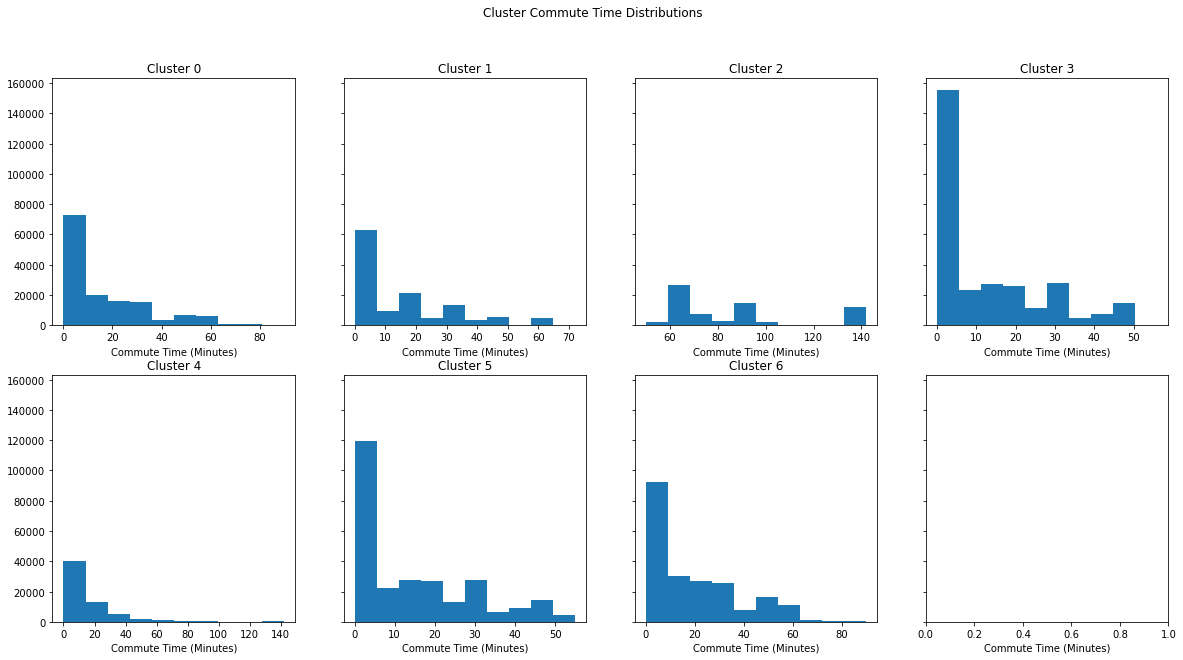

In [178]:
fig, axs = plt.subplots(2, 4, sharey=True, figsize=(20,10))
fig.suptitle("Cluster Commute Time Distributions")

axs[0, 0].hist(clust0['TRANTIME'])
axs[0, 0].set_title('Cluster 0')
axs[0, 1].hist(clust1['TRANTIME'])
axs[0, 1].set_title('Cluster 1')
axs[0, 2].hist(clust2['TRANTIME'])
axs[0, 2].set_title('Cluster 2')
axs[0, 3].hist(clust3['TRANTIME'])
axs[0, 3].set_title('Cluster 3')
axs[1, 0].hist(clust4['TRANTIME'])
axs[1, 0].set_title('Cluster 4')
axs[1, 1].hist(clust5['TRANTIME'])
axs[1, 1].set_title('Cluster 5')
axs[1, 2].hist(clust6['TRANTIME'])
axs[1, 2].set_title('Cluster 6')

for ax in axs.flat:
    ax.set(xlabel='Commute Time (Minutes)')

## Drinking Water

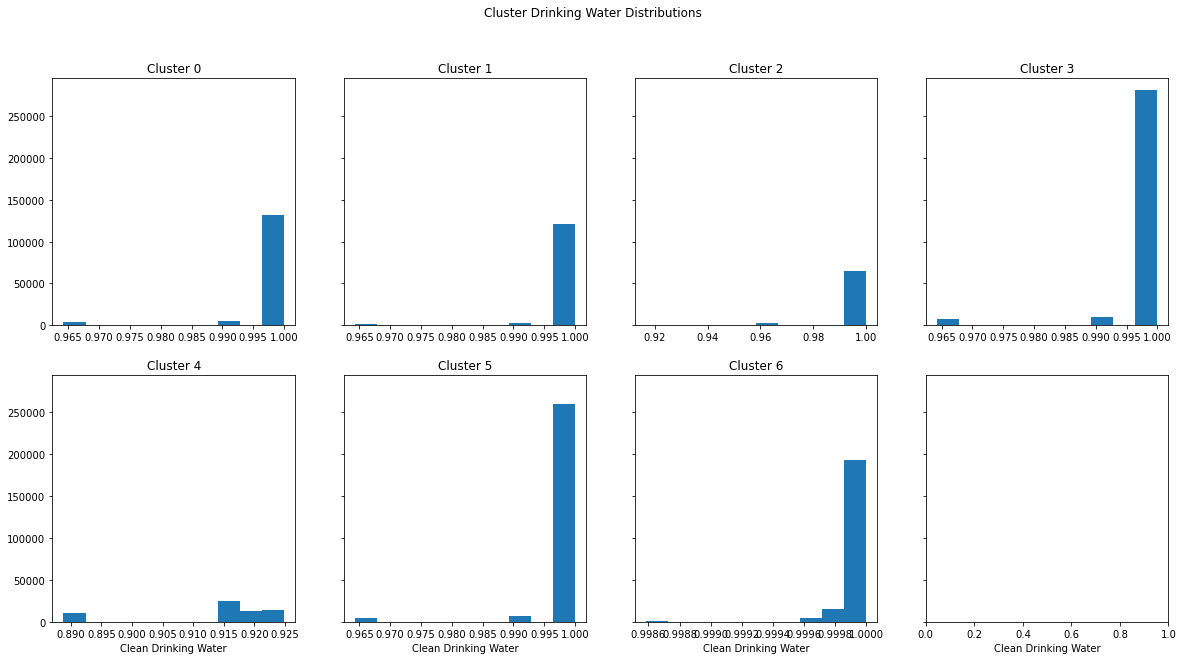

In [186]:
fig, axs = plt.subplots(2, 4, sharey=True, figsize=(20,10))
fig.suptitle("Cluster Drinking Water Distributions")

axs[0, 0].hist(clust0['DrinkingWater'])
axs[0, 0].set_title('Cluster 0')
axs[0, 1].hist(clust1['DrinkingWater'])
axs[0, 1].set_title('Cluster 1')
axs[0, 2].hist(clust2['DrinkingWater'])
axs[0, 2].set_title('Cluster 2')
axs[0, 3].hist(clust3['DrinkingWater'])
axs[0, 3].set_title('Cluster 3')
axs[1, 0].hist(clust4['DrinkingWater'])
axs[1, 0].set_title('Cluster 4')
axs[1, 1].hist(clust5['DrinkingWater'])
axs[1, 1].set_title('Cluster 5')
axs[1, 2].hist(clust6['DrinkingWater'])
axs[1, 2].set_title('Cluster 6')

for ax in axs.flat[4:]:
    ax.set(xlabel='Clean Drinking Water')

## Early Education

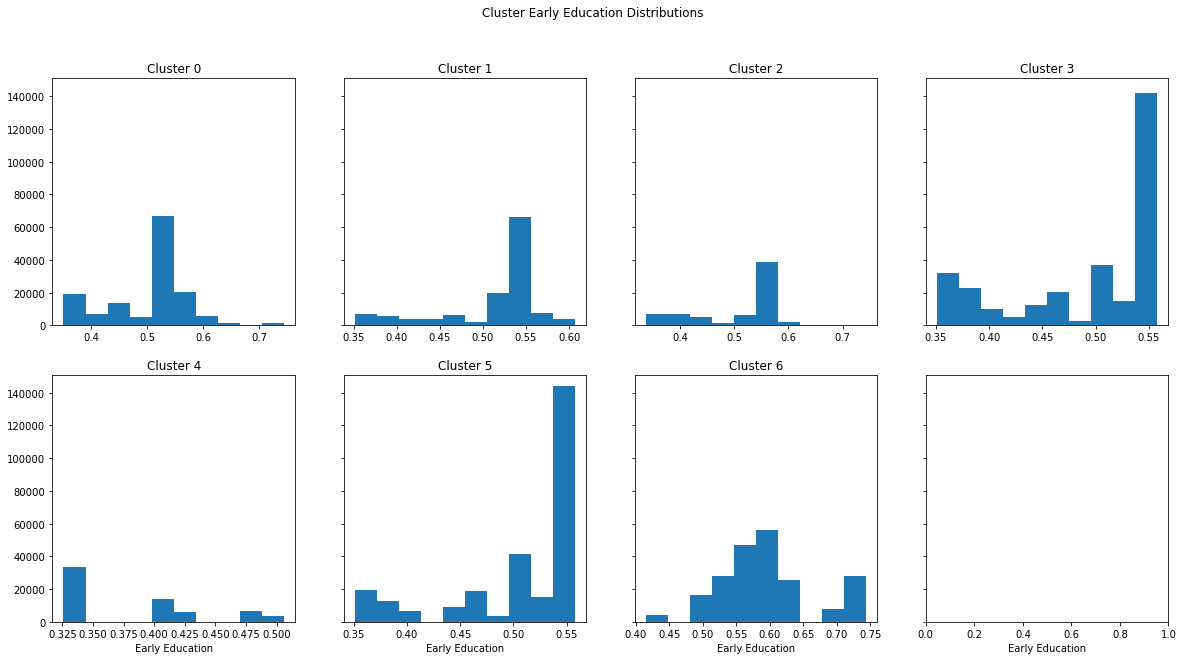

In [185]:
fig, axs = plt.subplots(2, 4, sharey=True, figsize=(20,10))
fig.suptitle("Cluster Early Education Distributions")

axs[0, 0].hist(clust0['EarlyEd'])
axs[0, 0].set_title('Cluster 0')
axs[0, 1].hist(clust1['EarlyEd'])
axs[0, 1].set_title('Cluster 1')
axs[0, 2].hist(clust2['EarlyEd'])
axs[0, 2].set_title('Cluster 2')
axs[0, 3].hist(clust3['EarlyEd'])
axs[0, 3].set_title('Cluster 3')
axs[1, 0].hist(clust4['EarlyEd'])
axs[1, 0].set_title('Cluster 4')
axs[1, 1].hist(clust5['EarlyEd'])
axs[1, 1].set_title('Cluster 5')
axs[1, 2].hist(clust6['EarlyEd'])
axs[1, 2].set_title('Cluster 6')

for ax in axs.flat[4:]:
    ax.set(xlabel='Early Education')

## Prosperous Neighborhoods

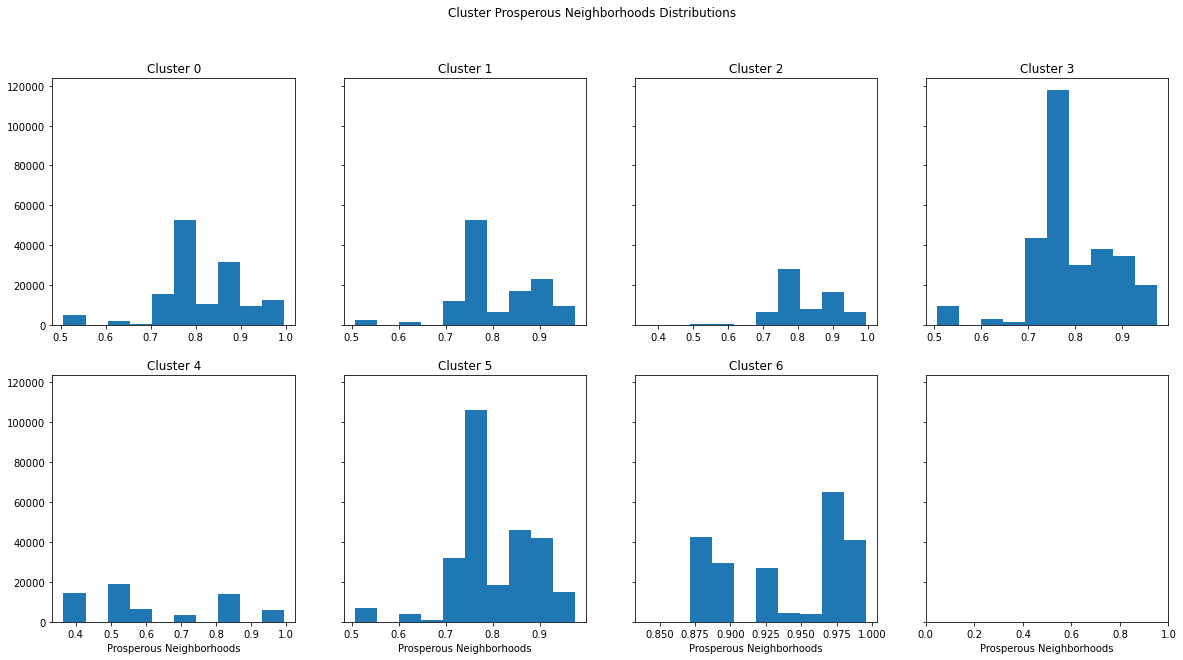

In [184]:
fig, axs = plt.subplots(2, 4, sharey=True, figsize=(20,10))
fig.suptitle("Cluster Prosperous Neighborhoods Distributions")

axs[0, 0].hist(clust0['ProspNeigh'])
axs[0, 0].set_title('Cluster 0')
axs[0, 1].hist(clust1['ProspNeigh'])
axs[0, 1].set_title('Cluster 1')
axs[0, 2].hist(clust2['ProspNeigh'])
axs[0, 2].set_title('Cluster 2')
axs[0, 3].hist(clust3['ProspNeigh'])
axs[0, 3].set_title('Cluster 3')
axs[1, 0].hist(clust4['ProspNeigh'])
axs[1, 0].set_title('Cluster 4')
axs[1, 1].hist(clust5['ProspNeigh'])
axs[1, 1].set_title('Cluster 5')
axs[1, 2].hist(clust6['ProspNeigh'])
axs[1, 2].set_title('Cluster 6')

for ax in axs.flat[4:]:
    ax.set(xlabel='Prosperous Neighborhoods')

## Feature Correlations

In [ ]:
Xcorr=dfXfin.iloc[:, [0,1,2,3,4,5,6,7]]
Xcorr.head()

<AxesSubplot:>

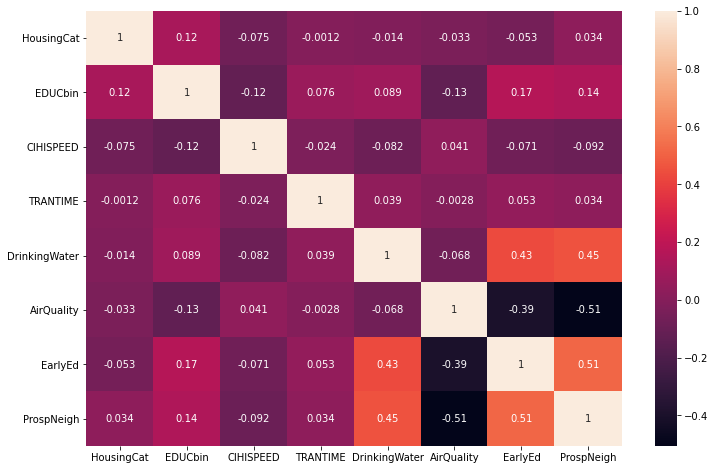

In [127]:
plt.subplots(figsize=(15,8))
sns.heatmap(Xcorr.corr(), annot = True)